# 1. Dataset Construction

In [26]:
import pandas as pd
# Load the data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

#Remove the specified columns
columns_to_remove = ['MonthlyCharges', 'OnlineSecurity', 'StreamingTV', 'InternetService', 'Partner']
df = df.drop(columns=columns_to_remove)
# Verify the shape of the dataset
print(f"Dataset shape: {df.shape}")

# Save the modified dataset
df.to_csv('modified_Telco_Customer_Churn.csv', index=False)

Dataset shape: (7043, 16)


# 2. Model Development

## 2.1 Problem Statement
### Context 
Big Retail, an online retail company in Adelaide, Australia is encounter declining visitor numbers and low conversion rates. To address these challenges, the company is pivoting towards a data-driven strategy, starting with an analysis of customer churn. 
### The Problem 
Customer churn, or customer attrition, is a critical issue for the retail industry. High churn rates can significantly impact the revenue of a company,especially Big Retail. 
The company is experiencing a decline in visitors to its website and conversion rates are low, indication issues with customer retention. 
### Solution 
- Develop a predictive model to identify customers at high risk of churning 
- Uncover key factors contributing to customer churn
- Provide actionable insights to improve customer retention strategies 
### Approach 
- Analyze historical customer data to identify patterns and predictors of churn
- Develop and evaluate a machine learning model (decision tree) to predict customer churn
- Interpret the model results to provide actionable business insights



## 2.2 Exploratory Data Analysis

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('modified_Telco_Customer_Churn.csv')

# Basic statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

       SeniorCitizen       tenure
count    7043.000000  7043.000000
mean        0.162147    32.371149
std         0.368612    24.559481
min         0.000000     0.000000
25%         0.000000     9.000000
50%         0.000000    29.000000
75%         0.000000    55.000000
max         1.000000    72.000000
customerID          0
gender              0
SeniorCitizen       0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
TotalCharges        0
Churn               0
dtype: int64


In [28]:
print(df['TotalCharges'].describe())
print(df['Churn'].value_counts(normalize=True))
print(df.dtypes)

count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64
customerID          object
gender              object
SeniorCitizen        int64
Dependents          object
tenure               int64
PhoneService        object
MultipleLines       object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingMovies     object
Contract            object
PaperlessBilling    object
PaymentMethod       object
TotalCharges        object
Churn               object
dtype: object


In [29]:
# Separate numeric and categorical columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

print("Numeric columns:", numeric_columns)
print("Categorical columns:", categorical_columns)

Numeric columns: Index(['SeniorCitizen', 'tenure'], dtype='object')
Categorical columns: Index(['customerID', 'gender', 'Dependents', 'PhoneService', 'MultipleLines',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges',
       'Churn'],
      dtype='object')


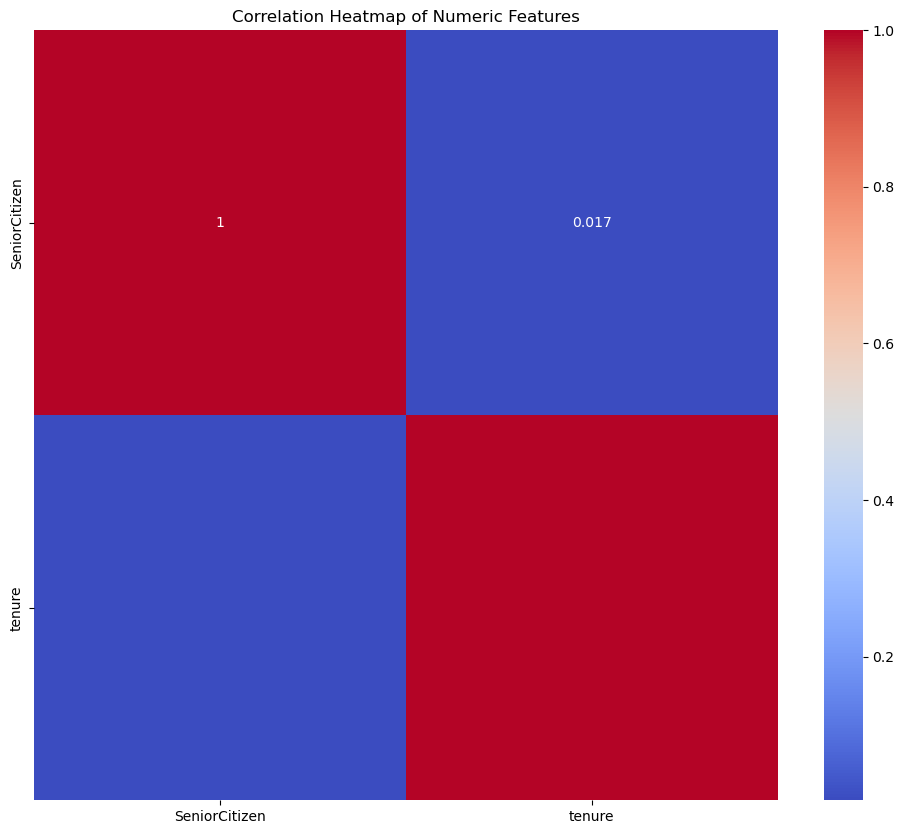

In [30]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

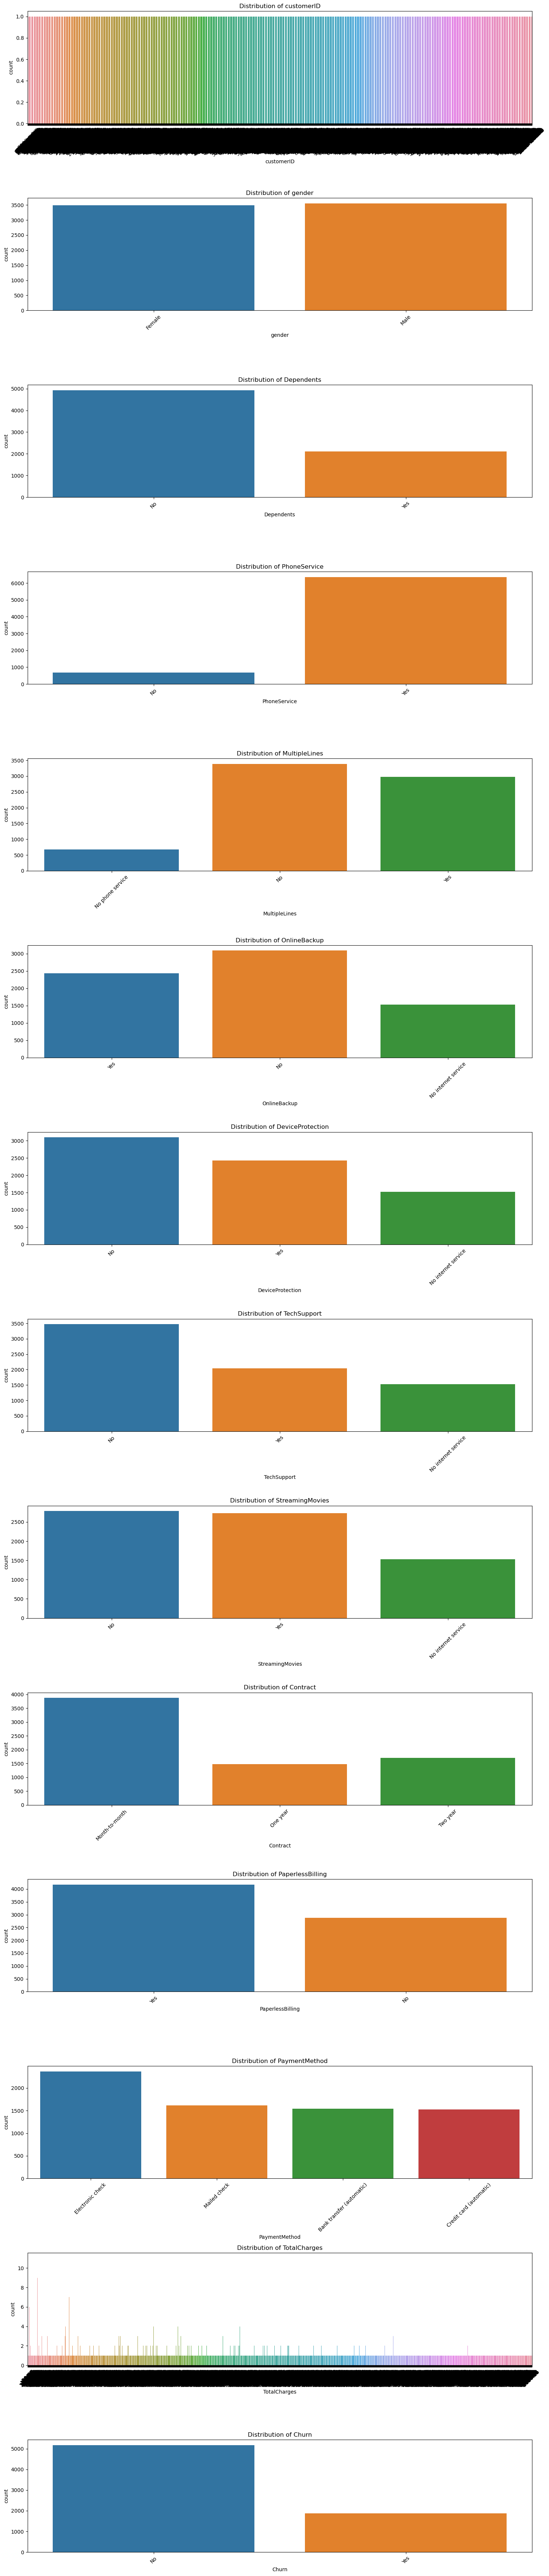

In [31]:
# Distribution of categorical variables
fig, axs = plt.subplots(len(categorical_columns), 1, figsize=(15, 5*len(categorical_columns)))
for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=df, ax=axs[i] if len(categorical_columns) > 1 else axs)
    axs[i].set_title(f'Distribution of {col}') if len(categorical_columns) > 1 else axs.set_title(f'Distribution of {col}')
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45) if len(categorical_columns) > 1 else axs.set_xticklabels(axs.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


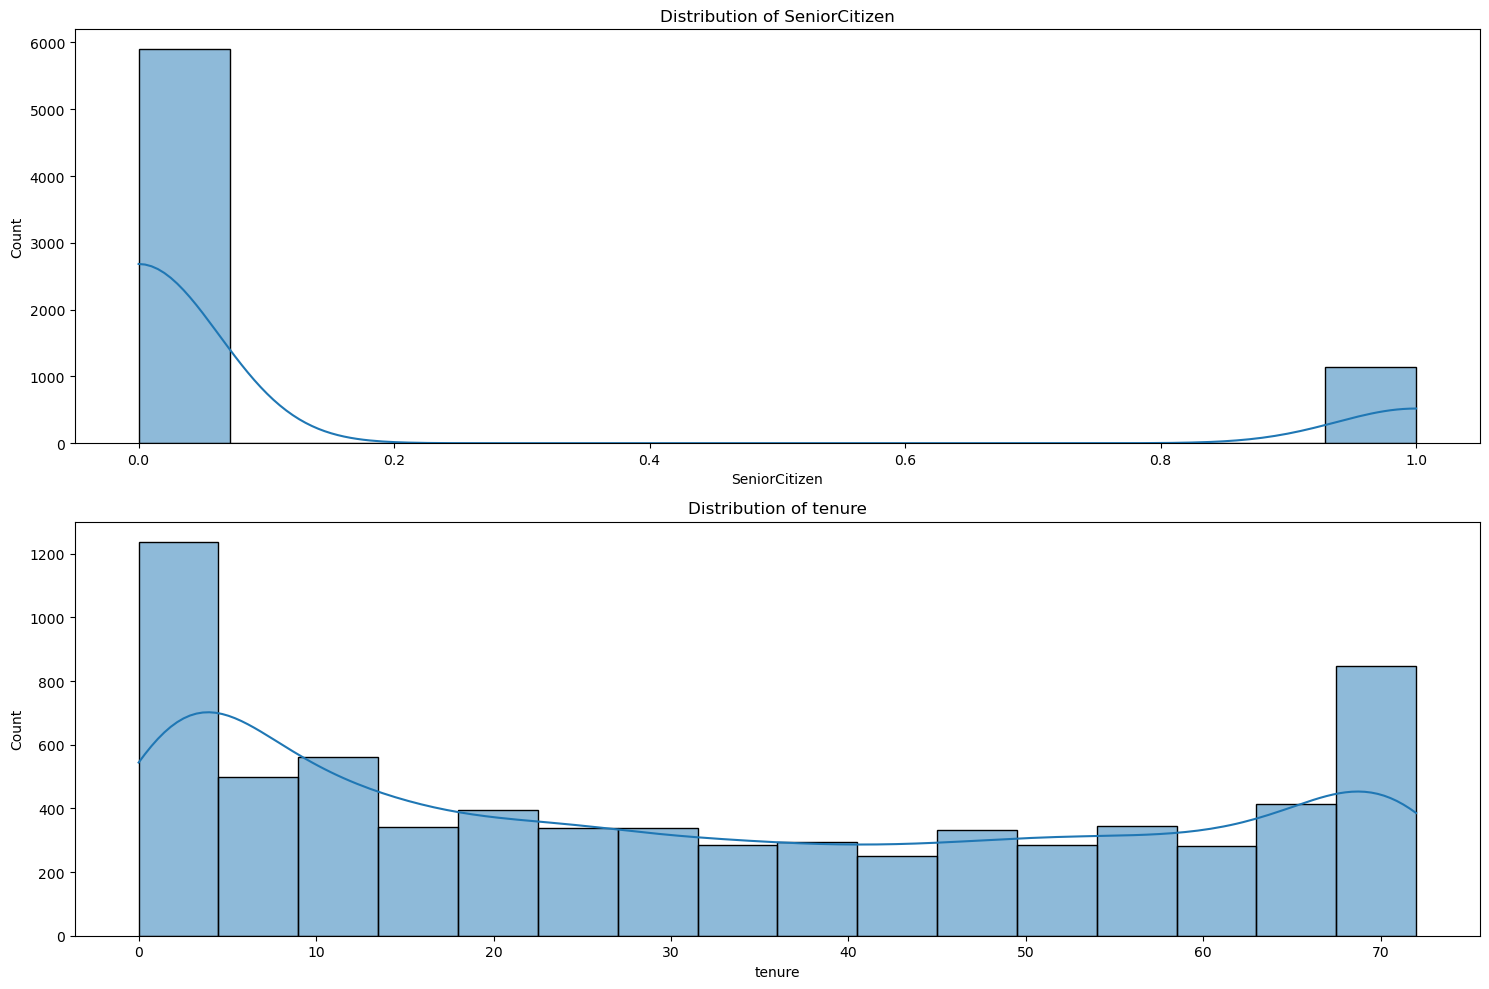

In [32]:
# Distribution of numeric variables
fig, axs = plt.subplots(len(numeric_columns), 1, figsize=(15, 5*len(numeric_columns)))
for i, col in enumerate(numeric_columns):
    sns.histplot(df[col], kde=True, ax=axs[i] if len(numeric_columns) > 1 else axs)
    axs[i].set_title(f'Distribution of {col}') if len(numeric_columns) > 1 else axs.set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

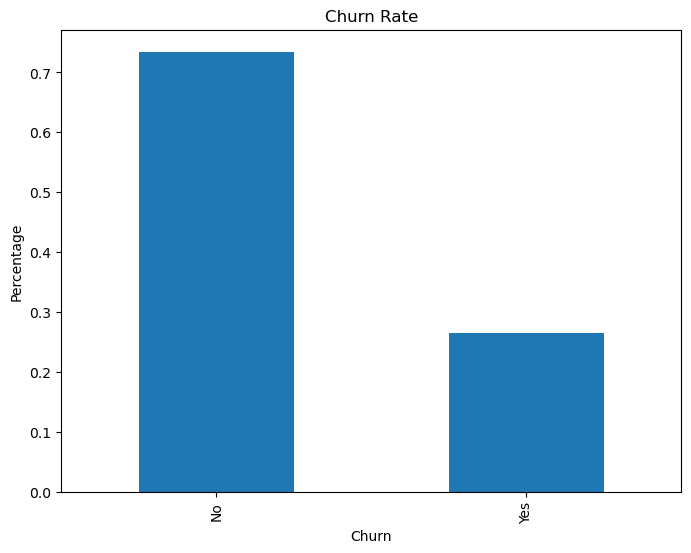

In [33]:
# Churn rate analysis
churn_rate = df['Churn'].value_counts(normalize=True)
plt.figure(figsize=(8, 6))
churn_rate.plot(kind='bar')
plt.title('Churn Rate')
plt.ylabel('Percentage')
plt.show()

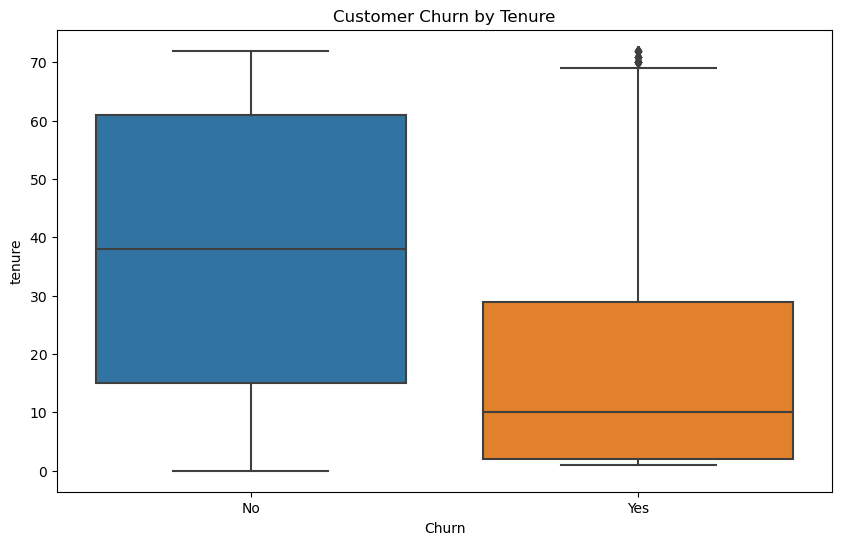

In [34]:
# Analyze churn by tenure
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Customer Churn by Tenure')
plt.show()

## 2.3 Data Cleaning & Feature Selection


In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Handle missing values in TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("Missing values before imputation:", df['TotalCharges'].isna().sum())

imputer = SimpleImputer(strategy='mean')
df['TotalCharges'] = imputer.fit_transform(df[['TotalCharges']])
print("Missing values after imputation:", df['TotalCharges'].isna().sum())

# Save original TotalCharges
df['TotalCharges_Original'] = df['TotalCharges'].copy()

# Identify numerical and categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = numerical_columns.drop(['TotalCharges_Original'])

# Scale numerical features
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Create binary target variable
df['Churn_Binary'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Encode categorical variables
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Prepare features and target
X = df.drop(['Churn', 'Churn_Binary', 'TotalCharges'], axis=1)
y = df['Churn_Binary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Missing values before imputation: 11
Missing values after imputation: 0
Training set shape: (5634, 15)
Testing set shape: (1409, 15)


## 2.4 Model Building 


Best Decision Tree Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best CV Score: 0.8188259432439778

Best Random Forest Parameters: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best CV Score: 0.8371688254709424

Decision Tree Results:
Accuracy: 0.773
AUC-ROC: 0.810
Average Precision: 0.547

Confusion Matrix:
[[947  88]
 [232 142]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.86      1035
           1       0.62      0.38      0.47       374

    accuracy                           0.77      1409
   macro avg       0.71      0.65      0.66      1409
weighted avg       0.75      0.77      0.75      1409


Random Forest Results:
Accuracy: 0.783
AUC-ROC: 0.834
Average Precision: 0.645

Confusion Matrix:
[[945  90]
 [216 158]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86 

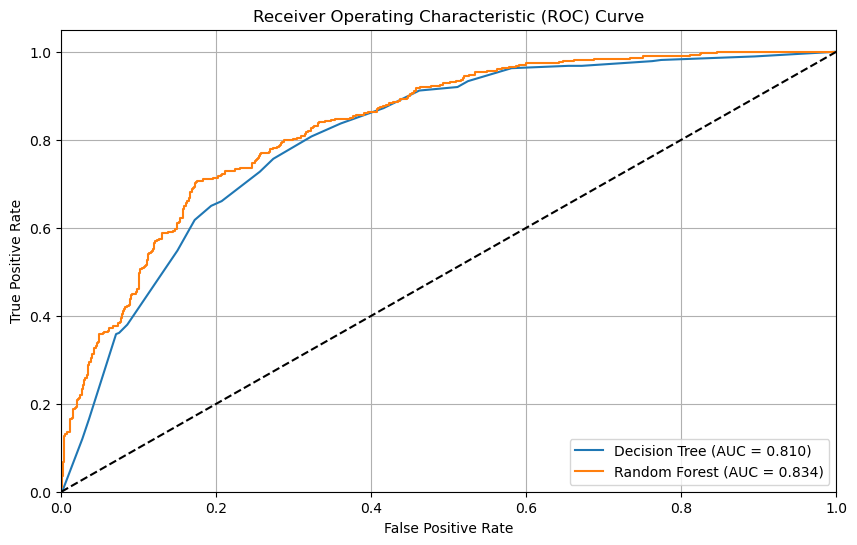

<Figure size 1200x600 with 0 Axes>

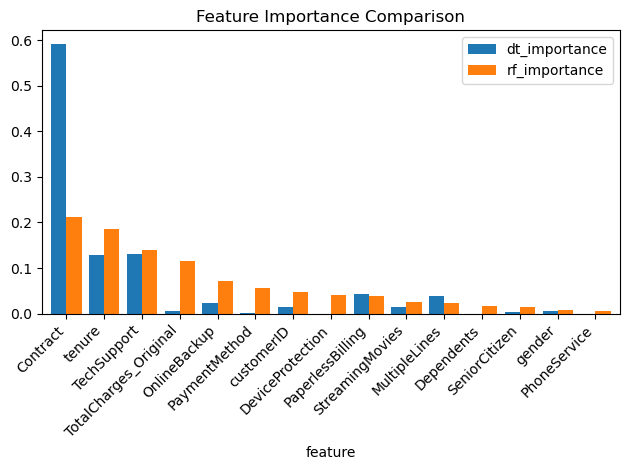


Top 10 Most Important Features (Decision Tree):
                  feature  dt_importance
11               Contract       0.591832
4                  tenure       0.127769
9             TechSupport       0.131531
14  TotalCharges_Original       0.004876
7            OnlineBackup       0.022587
13          PaymentMethod       0.001254
0              customerID       0.014323
8        DeviceProtection       0.000000
12       PaperlessBilling       0.042740
10        StreamingMovies       0.014902

Top 10 Most Important Features (Random Forest):
                  feature  rf_importance
11               Contract       0.211179
4                  tenure       0.185861
9             TechSupport       0.140316
14  TotalCharges_Original       0.114757
7            OnlineBackup       0.070753
13          PaymentMethod       0.056977
0              customerID       0.046897
8        DeviceProtection       0.041096
12       PaperlessBilling       0.038591
10        StreamingMovies       0.025064


In [36]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, 
                           classification_report, precision_recall_curve, 
                           average_precision_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate Decision Tree and Random Forest models
    """
    # Decision Tree
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_params = {
        'max_depth': [3, 5, 7, 9],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    dt_grid = GridSearchCV(dt_model, dt_params, cv=5, scoring='roc_auc', n_jobs=-1)
    dt_grid.fit(X_train, y_train)

    print("\nBest Decision Tree Parameters:", dt_grid.best_params_)
    print("Best CV Score:", dt_grid.best_score_)
    dt_best = dt_grid.best_estimator_

    # Random Forest
    rf_model = RandomForestClassifier(random_state=42)
    rf_params = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='roc_auc', n_jobs=-1)
    rf_grid.fit(X_train, y_train)

    print("\nBest Random Forest Parameters:", rf_grid.best_params_)
    print("Best CV Score:", rf_grid.best_score_)
    rf_best = rf_grid.best_estimator_

    # Feature importance analysis
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'dt_importance': dt_best.feature_importances_,
        'rf_importance': rf_best.feature_importances_
    })
    
    # Sort by random forest importance
    feature_importance = feature_importance.sort_values('rf_importance', ascending=False)

    # Evaluate models
    models = [('Decision Tree', dt_best), ('Random Forest', rf_best)]
    results = {}

    for name, model in models:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'auc_roc': roc_auc_score(y_test, y_pred_proba),
            'avg_precision': average_precision_score(y_test, y_pred_proba),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred),
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

        print(f"\n{name} Results:")
        print(f"Accuracy: {results[name]['accuracy']:.3f}")
        print(f"AUC-ROC: {results[name]['auc_roc']:.3f}")
        print(f"Average Precision: {results[name]['avg_precision']:.3f}")
        print("\nConfusion Matrix:")
        print(results[name]['confusion_matrix'])
        print("\nClassification Report:")
        print(results[name]['classification_report'])

    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    for name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {result["auc_roc"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    feature_importance.plot(x='feature', y=['dt_importance', 'rf_importance'], 
                          kind='bar', width=0.8)
    plt.title('Feature Importance Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return dt_best, rf_best, feature_importance, results

# Train and evaluate the models
dt_best, rf_best, feature_importance, results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

# Print top 10 most important features
# Print top 10 most important features
print("\nTop 10 Most Important Features (Decision Tree):")
print(feature_importance[['feature', 'dt_importance']].head(10))
print("\nTop 10 Most Important Features (Random Forest):")
print(feature_importance[['feature', 'rf_importance']].head(10))

## 2.5 Feature Importance and Model Interpretation

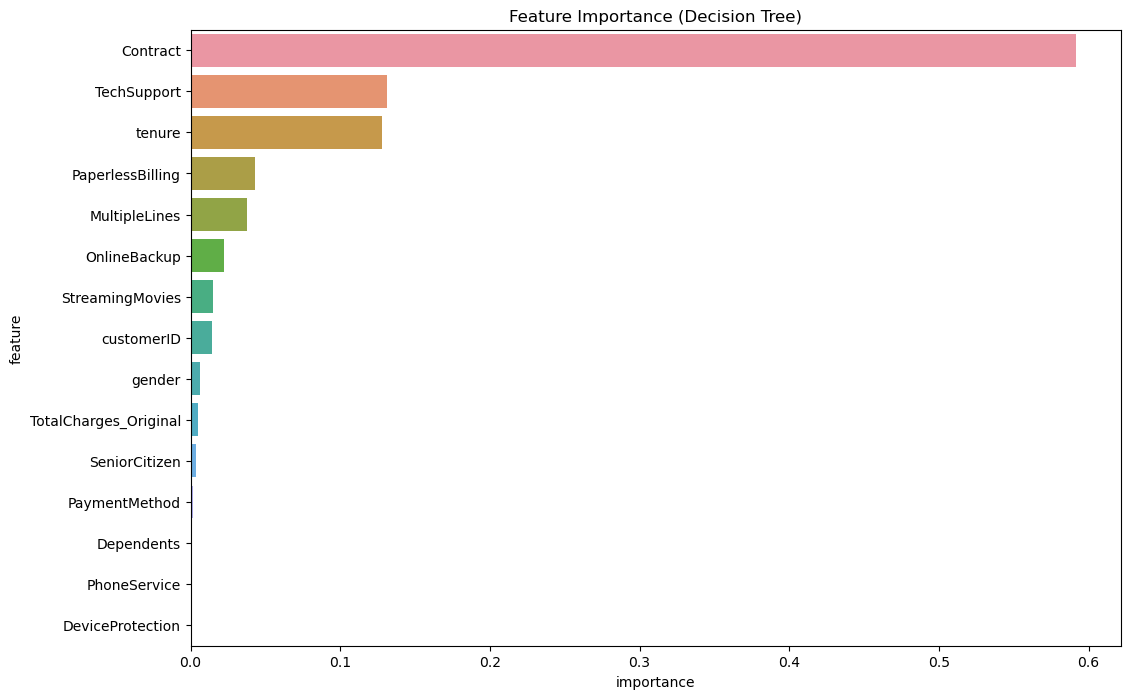

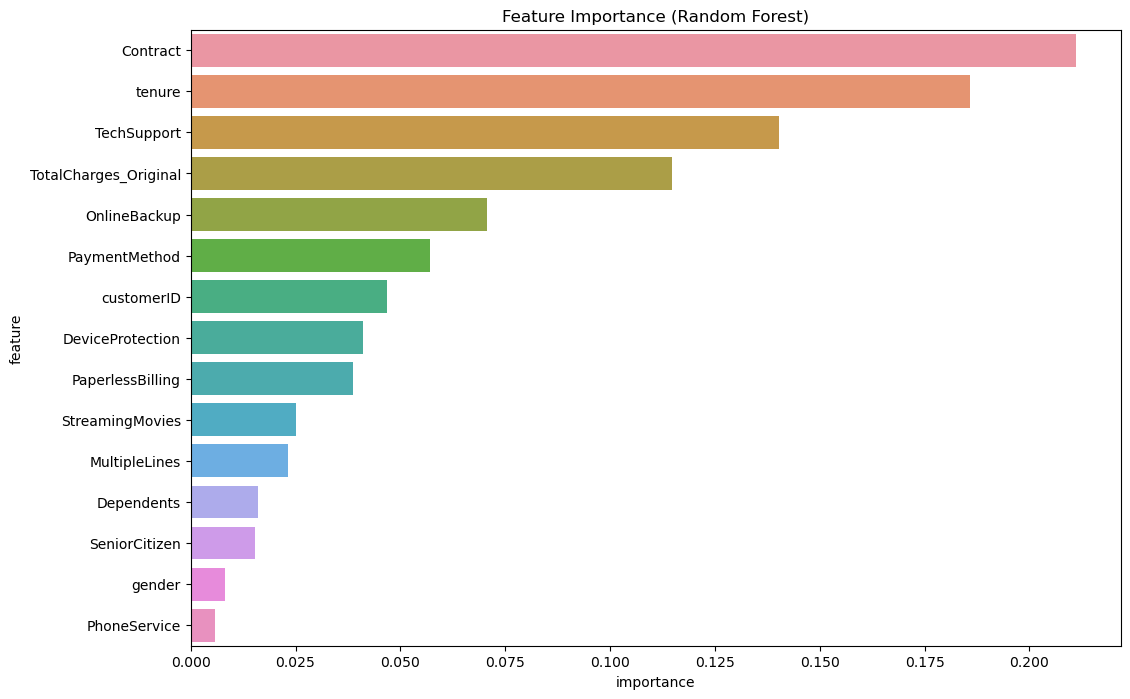

In [37]:
# Decision Tree feature importance
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': dt_best.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Decision Tree)')
plt.show()

# Random Forest feature importance
plt.figure(figsize=(12, 8))
feature_importance_rf = pd.DataFrame({'feature': X.columns, 'importance': rf_best.feature_importances_})
feature_importance_rf = feature_importance_rf.sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feature_importance_rf)
plt.title('Feature Importance (Random Forest)')
plt.show()

## 2.6 Business Insights

Churn Rate Analysis by Top Features:

Contract:
          Churn_Rate  Total_Customers  Churned_Customers
Contract                                                
0              0.427             3875               1655
1              0.113             1473                166
2              0.028             1695                 48

TechSupport:
             Churn_Rate  Total_Customers  Churned_Customers
TechSupport                                                
0                 0.416             3473               1446
2                 0.152             2044                310
1                 0.074             1526                113

tenure:
           Churn_Rate  Total_Customers  Churned_Customers
tenure                                                   
-1.277445       0.620              613                380
-1.236724       0.517              238                123
-1.114563       0.481              133                 64
-1.155283       0.472              176                

C:\Users\chaul\AppData\Local\Temp\ipykernel_36024\3907490596.py:42: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\chaul\AppData\Local\Temp\ipykernel_36024\3907490596.py:42: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\chaul\AppData\Local\Temp\ipykernel_36024\3907490596.py:42: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\chaul\AppData\Local\Temp\ipykernel_36024\3907490596.py:42: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\chaul\AppData\Local\Temp\ipykernel_36024\3907490596.py:42: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


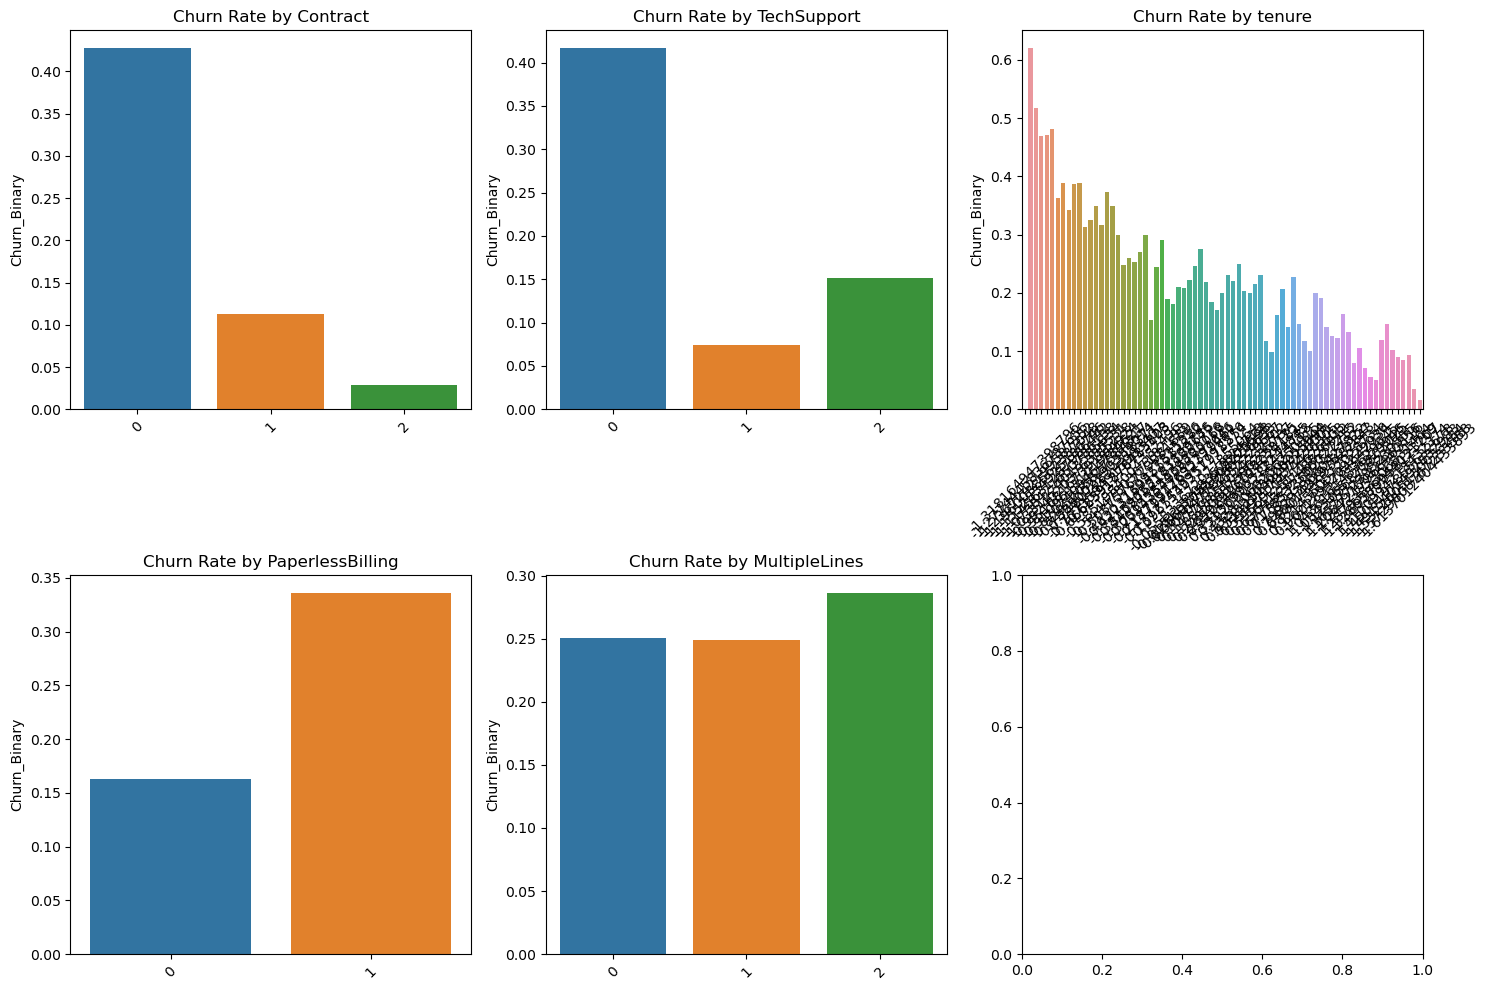


Analyzing High-Risk Customer Segments...

Top 10 High-Risk Customer Segments (minimum 20 customers):
                                Churn_Rate  Total_Customers  Churned_Customers
Contract TechSupport tenure                                                   
0        0           -1.277445       0.746              413                308
                     -0.910961       0.619               63                 39
                     -1.236724       0.616              172                106
                     -0.300156       0.607               28                 17
                     -1.155283       0.602              113                 68
                     -1.114563       0.588               80                 47
                     -1.196004       0.587              126                 74
                     -0.707359       0.520               50                 26
                     -1.073843       0.516               62                 32
                     -0.50375

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_churn_patterns(df, feature_importance, n_top_features=5):
    """
    Analyze churn patterns using top features from the model
    
    Parameters:
    df: DataFrame with original data (before encoding)
    feature_importance: DataFrame with feature importance from the model
    n_top_features: Number of top features to analyze
    """
    # Select top features
    top_features = feature_importance.head(n_top_features)['feature'].tolist()
    
    # Initialize figure for plotting
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    # Analyze each feature
    print("Churn Rate Analysis by Top Features:")
    churn_analysis = {}
    
    for idx, feature in enumerate(top_features):
        # Calculate churn rate and count for each category
        analysis = df.groupby(feature).agg({
            'Churn_Binary': ['mean', 'count', 'sum']
        }).round(3)
        
        analysis.columns = ['Churn_Rate', 'Total_Customers', 'Churned_Customers']
        analysis = analysis.sort_values('Churn_Rate', ascending=False)
        
        churn_analysis[feature] = analysis
        
        # Print analysis
        print(f"\n{feature}:")
        print(analysis)
        
        # Plot
        sns.barplot(
            data=df,
            x=feature,
            y='Churn_Binary',
            ax=axes[idx],
            ci=None
        )
        axes[idx].set_title(f'Churn Rate by {feature}')
        axes[idx].set_xlabel('')
        axes[idx].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze high-risk combinations
    print("\nAnalyzing High-Risk Customer Segments...")
    
    # Use top 3 features for combinations to keep it manageable
    top_3_features = top_features[:3]
    
    high_risk_segments = df.groupby(top_3_features).agg({
        'Churn_Binary': ['mean', 'count', 'sum']
    }).round(3)
    
    high_risk_segments.columns = ['Churn_Rate', 'Total_Customers', 'Churned_Customers']
    high_risk_segments = high_risk_segments[high_risk_segments['Total_Customers'] >= 20]  # Filter for segments with enough customers
    high_risk_segments = high_risk_segments.sort_values('Churn_Rate', ascending=False)
    
    print("\nTop 10 High-Risk Customer Segments (minimum 20 customers):")
    print(high_risk_segments.head(10))
    
    # Calculate overall statistics
    total_customers = len(df)
    total_churned = df['Churn_Binary'].sum()
    overall_churn_rate = total_churned / total_customers
    
    print(f"\nOverall Statistics:")
    print(f"Total Customers: {total_customers}")
    print(f"Total Churned Customers: {int(total_churned)}")
    print(f"Overall Churn Rate: {overall_churn_rate:.2%}")
    
    return churn_analysis, high_risk_segments

# Run the analysis
churn_analysis, high_risk_segments = analyze_churn_patterns(df, feature_importance)


In [39]:
# Identify top churning customer segments
top_churn_features = feature_importance_rf.head(5)['feature'].tolist()
churn_segments = df.groupby(top_churn_features)['Churn'].mean().sort_values(ascending=False).head(10)

print("Top Churning Customer Segments:")
print(churn_segments)

# Calculate potential revenue saved by reducing churn
avg_customer_value = df['TotalCharges_Original'].mean()
print(f"\nAverage Customer Value: ${avg_customer_value:.2f}")
current_churn_rate = df['Churn_Binary'].mean()
print(f"Current Churn Rate: {current_churn_rate:.2f}")
potential_churn_reduction = 0.1 # Assume we can reduce churn by 10%

potential_savings = avg_customer_value * len(df) * current_churn_rate * potential_churn_reduction
print(f"\nPotential Annual Revenue Saved: ${potential_savings:.2f}")


Top Churning Customer Segments:
Contract  tenure     TechSupport  TotalCharges_Original  OnlineBackup
0         -1.277445  0            23.45                  0               1.0
          -0.870241  0            824.75                 2               1.0
                                  1078.90                0               1.0
                                  1056.95                0               1.0
                                  1047.70                0               1.0
                                  997.65                 0               1.0
                                  906.85                 0               1.0
                                  896.90                 2               1.0
2          1.369379  2            5154.60                2               1.0
0          0.962175  2            5124.60                2               1.0
Name: Churn, dtype: float64

Average Customer Value: $2283.30
Current Churn Rate: 0.27

Potential Annual Revenue Saved: $426748.